In [1]:
import pandas as pd
import pandas_gbq

from github import Github
from google.cloud import bigquery
%load_ext google.cloud.bigquery

In [2]:
import pydata_google_auth
credentials = pydata_google_auth.get_user_credentials(
    ['https://www.googleapis.com/auth/bigquery'],
)

In [3]:
year = 'year.2017'
query = """SELECT created_at, repo.name FROM githubarchive.{0} WHERE RAND() < 1500/(SELECT COUNT(*) FROM `githubarchive.{0}`) ORDER BY created_at;""".format(year) 
project_id = 'cs515-term'

In [4]:
import pandas as pd
df = pd.read_gbq(query, project_id=project_id, dialect='standard', credentials=credentials)

repos = df['name']
dates = df['created_at']

Downloading: 100%|██████████| 1498/1498 [00:00<00:00, 6987.17rows/s]


In [5]:
from github import Github, UnknownObjectException, GithubException
from tqdm import tqdm

with open('password', 'r') as file:
    password = file.read().replace('\n', '')

g = Github("siddhik97", password)
language_array = []

for repo in tqdm(repos):
    try:
        repo_details = g.get_repo(repo)
        if repo_details.language is not None:
            language_array.append(repo_details.language)
        else:
            language_array.append("NaN")
    except (UnknownObjectException, GithubException):
        language_array.append("NaN")
        pass

100%|██████████| 1498/1498 [03:50<00:00,  6.49it/s]


In [6]:
df['lang'] = pd.DataFrame(language_array, columns=['languages'])
date_new = df["created_at"].astype(str).str.split(" ", n = 1, expand = True)
df["date"] = date_new[0]

In [7]:
import pandas as pd

final_df = pd.DataFrame(columns=['language', 'date'])
final_df['date'] = df['date']
final_df['language'] = df['lang']

In [8]:
final_df

,language,date
0,JavaScript,2017-01-01
1,NaN,2017-01-01
2,Python,2017-01-02
3,C#,2017-01-02
4,Python,2017-01-02
...,...,...
1493,NaN,2017-12-31
1494,NaN,2018-01-01
1495,NaN,2018-01-01
1496,NaN,2018-01-01


In [9]:
lang_date_df = final_df[~final_df["language"].str.contains("NaN")]
lang_date_df

,language,date
0,JavaScript,2017-01-01
2,Python,2017-01-02
3,C#,2017-01-02
4,Python,2017-01-02
5,JavaScript,2017-01-03
...,...,...
268,JavaScript,2017-03-14
269,HTML,2017-03-15
270,HTML,2017-03-15
271,Java,2017-03-16


(array([87., 29., 38., 18.,  4.,  3., 11.,  6.,  5.,  4.]),
 array([ 0. ,  3.5,  7. , 10.5, 14. , 17.5, 21. , 24.5, 28. , 31.5, 35. ]),
 <a list of 10 Patch objects>)

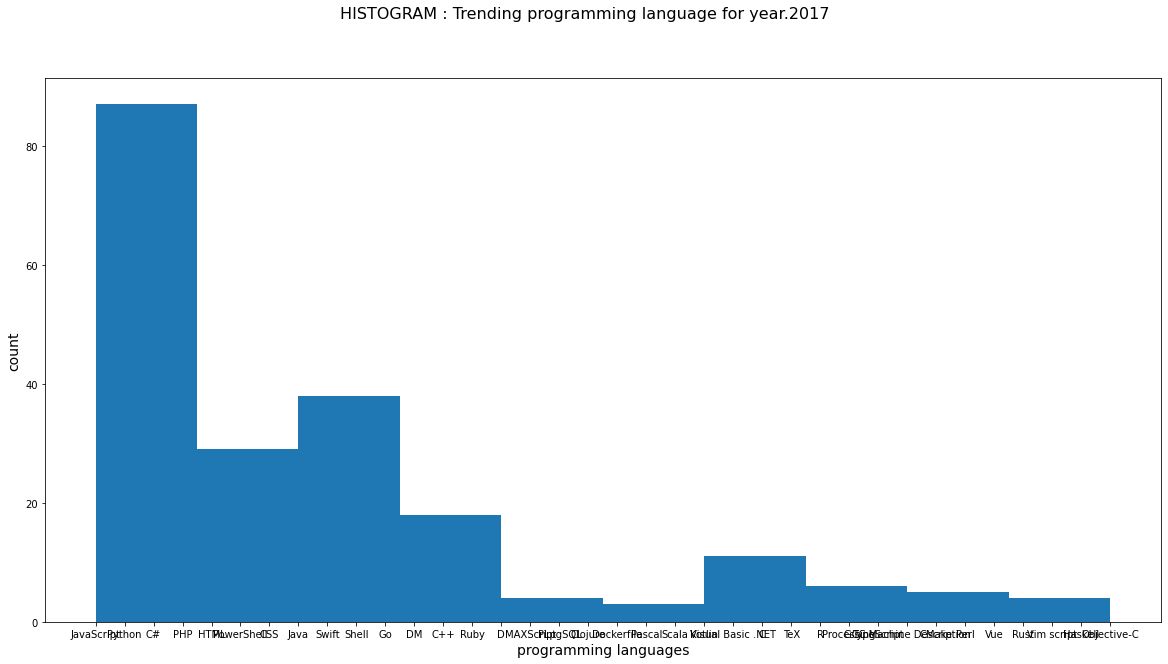

In [10]:
from matplotlib import pyplot as plt 
plt.figure(figsize=(20,10))
plt.suptitle('HISTOGRAM : Trending programming language for {0}'.format(year), fontsize=16)
plt.xlabel('programming languages', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.hist(lang_date_df['language'])

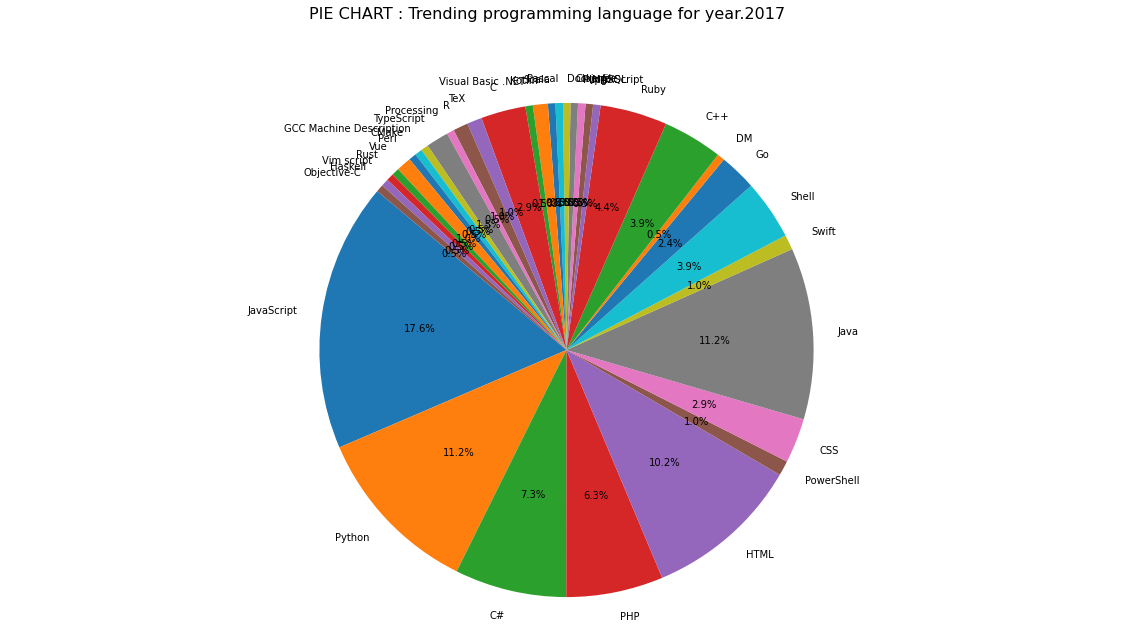

In [11]:
import matplotlib.pyplot as plt
from collections import Counter

label_sizes = Counter(lang_date_df['language'])
top_ten = label_sizes.most_common(10)    

# Data to plot
labels = list(label_sizes.keys())
sizes = list(label_sizes.values())

# Plot
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 10})

plt.suptitle('PIE CHART : Trending programming language for {0}'.format(year), fontsize=16)

plt.pie(sizes,labels=labels, autopct='%1.1f%%', startangle=140)

plt.axis('equal')
#plt.show()
plt.savefig('pie_chat.png')

In [12]:
label_sizes.most_common(10)

[('JavaScript', 36),
 ('Python', 23),
 ('Java', 23),
 ('HTML', 21),
 ('C#', 15),
 ('PHP', 13),
 ('Ruby', 9),
 ('Shell', 8),
 ('C++', 8),
 ('CSS', 6)]

In [13]:
trending_languages = [x[0] for x in label_sizes.most_common(3)]

In [14]:
trending_df = final_df[final_df["language"].str.contains('|'.join(trending_languages))]

In [15]:
trending_df.head()

,language,date
0,JavaScript,2017-01-01
2,Python,2017-01-02
4,Python,2017-01-02
5,JavaScript,2017-01-03
12,Java,2017-01-04


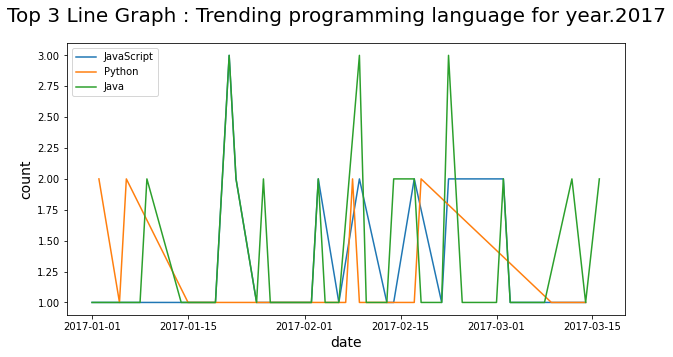

In [16]:
import matplotlib.pyplot as plt

#ax = plt.gca()
plt.figure(figsize=(10,5))

for language in trending_languages:
    new_df = trending_df[trending_df["language"].str.contains(language)]
    new_df.columns = [language, 'date_full']
    new_new_df = new_df.groupby(by=new_df['date_full'].astype('datetime64[ns]')).count()
    #print(new_new_df.index)
    plt.plot(new_new_df.index, new_new_df[language], label=str(language))

plt.legend(loc="upper left")
plt.suptitle('Top 3 Line Graph : Trending programming language for {0}'.format(year), fontsize=20)
plt.xlabel('date', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.show()